In [87]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sns
import warnings
import os
from scipy.stats import ttest_ind, f_oneway, kruskal
from scipy.stats import chi2_contingency

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)



In [88]:
# Leitura do dataset refinado
diretorio_acidentes = 'data/refined/acidentes_recife_normalizados.csv'
df_acidentes = pd.read_csv(diretorio_acidentes, sep = ',')
       

In [89]:
df_acidentes.head(3)

,Unnamed: 0,data,hora,natureza_acidente,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,Protocolo,auto_bin,moto_bin,ciclom_bin,ciclista_bin,pedestre_bin,onibus_bin,caminhao_bin,viatura_bin,outros_bin,vitimas_bin,vitimasfatais_bin,dia_da_semana,mes,ano,estacao
0,0,2021-01-01,19:44:00,Não fatal,FINALIZADA,MADALENA,RUA BENFICA,EM FRENTE AO EXTRA NA SAIDA,MADALENA,COLISÃO FRONTAL,NaN,NaN,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday,1.0,2021.0,Verão
1,1,2021-01-01,23:15:40,Não fatal,FINALIZADA,VÁRZEA,AV CAXANGA,EM FRENTE A UPA DA CAXANGA,VÁRZEA,COLISÃO TRASEIRA,NaN,NaN,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday,1.0,2021.0,Verão
2,2,2021-01-02,10:54:00,Não fatal,FINALIZADA,VASCO DA GAMA,RUA RESPLENDOR,AO LADO DO COLEGIO ADERBAL GALVÃO EM FRE...,VASCO DA GAMA,COLISÃO COM CICLISTA,NaN,NaN,0.00,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Saturday,1.0,2021.0,Verão


# Estatísticas descritivas

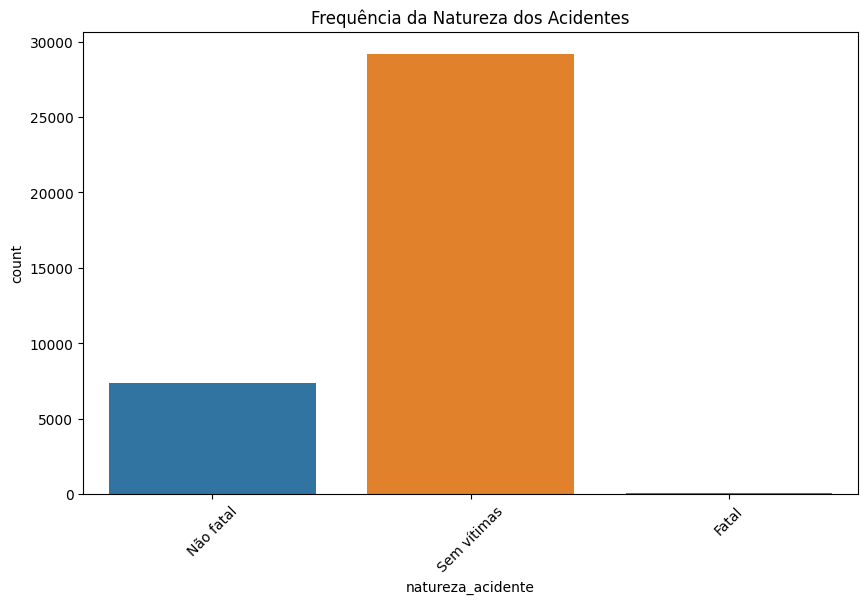

In [90]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_acidentes, x='natureza_acidente')
plt.title('Frequência da Natureza dos Acidentes')
plt.xticks(rotation=45)
plt.show()

# Testes de Hipótese

#### Feriados e Acidentes
Hipótese nula (H0): Não existe relação entre feriados e aumentos no índice de acidentes.

Hipótese alternativa (H1): Existe relação entre feriados e aumentos no índice de acidentes.

In [94]:
# Definindo uma lista de feriados principais
feriados = [
    "2021-01-01", "2021-03-02", "2021-04-02", "2021-04-21", 
    "2021-05-01", "2021-06-03", "2021-06-24", "2021-09-07", 
    "2021-10-12", "2021-11-02", "2021-11-15", "2021-12-25"
]

# Marcando feriados no dataframe
df_acidentes['feriado'] = df_acidentes['data'].isin(feriados).astype(int)

# Agrupar por data e feriado, contando o número de acidentes por dia
df_acidentes['count'] = 1 
grouped = df_acidentes.groupby(['data', 'feriado']).agg({'count': 'sum'}).reset_index()

# Média de acidentes em dias de feriado vs. dias normais
media_acidentes = grouped.groupby('feriado')['count'].mean()
print("Média de acidentes por tipo de dia:")
print(media_acidentes)

# Teste de hipótese: Comparando médias de acidentes em dias de feriado vs. dias não feriados
t_stat, p_value = ttest_ind(
    grouped[grouped['feriado'] == 1]['count'], 
    grouped[grouped['feriado'] == 0]['count'], 
    equal_var=False
)

print("Resultado do Teste t:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

Média de acidentes por tipo de dia:
feriado
0    33.796657
1     4.000000
Name: count, dtype: float64
Resultado do Teste t:
t-statistic: -21.841718287839765
p-value: 1.2104271893861676e-53


Nossa análise dos dados de trânsito mostrou que mais acidentes ocorrem durante os feriados do que em dias normais. Usamos uma medida estatística, chamada p-valor, para testar se essa diferença é por acaso. Com um p-valor menor que 0,05, descobrimos que a chance de essa diferença ocorrer por acaso é muito pequena. Isso sugere que os feriados realmente têm uma influência significativa no aumento dos acidentes de trânsito.

#### Tipo de veículo e quantidade de acidentes.
Hipótese Nula (H0): Não há diferença significativa na quantidade de acidentes com vítimas entre os tipos de veículos.

Hipótese Alternativa (H1): A quantidade de acidentes com vítimas varia significativamente entre os diferentes tipos de veículos (auto, moto, ciclomotor, ciclista, pedestre, ônibus, caminhão, viatura e outros).

In [92]:
# Criar uma tabela de contingência
tabela_contingencia = pd.crosstab(df_acidentes['natureza_acidente'], df_acidentes['estacao'])

# Realizar o teste qui-quadrado
chi2, p_value, dof, expected = chi2_contingency(tabela_contingencia)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p_value}")


Chi-squared: 154.93829602645198
P-value: 6.982563682222359e-31


Nossa análise estatística mostrou uma relação significativa entre as estações do ano e a natureza dos acidentes de trânsito em Recife. Isso significa que certos tipos de acidentes tendem a ocorrer com mais frequência em algumas estações do ano do que em outras. Com um valor de Chi-quadrado de 154.94 e um p-valor extremamente baixo (praticamente zero), podemos afirmar com confiança que essa variação sazonal não é devido ao acaso.